## Import and install dependencies

In [1]:
!pip install trl
!pip install peft
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 1.7 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 2.0 MB/s eta 0:00:00a 0:00:01m


In [2]:
data_path = "/kaggle/input/squad0"

In [3]:
import numpy as np
import torch
import random
import gc
from datasets import Dataset
import json
import time
import pandas as pd

from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig, PeftConfig, get_peft_model
from transformers import TrainingArguments
from transformers import GPT2Tokenizer, GPT2LMHeadModel

import os

2024-05-08 23:18:11.358036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 23:18:11.358138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 23:18:11.648125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Making the notebook deteministic

In [4]:
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


fix_random(seed=42)

Load the squad dataset

In [5]:
dataset = load_dataset('squad', split='train')
dataset = dataset.shuffle(seed=42)
dataset = dataset.select(range(20000)) 

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Here we are creating the dataset for training. The question and answer pairs have the following format:

{context}

Q: {question}

A: {answer}

In [6]:
def making_Question_With_Context(dataset):
    answers = [answer['text'][0] for answer in dataset['answers']] 
    questions = [question for question in dataset['question']] 
    contexts = [context for context in dataset['context']]
    contexts_with_question = [f"{context}\n\nQ: {question}\n\nA: {answer}"for question, context, answer in zip(questions, contexts, answers)]

    return Dataset.from_dict({'contexts_with_question': contexts_with_question})

In [7]:
os.environ["WANDB_DISABLED"] = "true"

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', padding_side='left')
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer.eos_token = "<|endoftext|>"
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [8]:
peft_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=["c_attn", "c_proj", "c_fc"],
        task_type="CAUSAL_LM",
        bias="none"
)


model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

datasetTrain = making_Question_With_Context(dataset)

training_args = TrainingArguments(
    output_dir="/kaggle/working",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    logging_dir='./logs',
    logging_steps=50,
    learning_rate=2e-5,
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    optim="adamw_torch_fused",
    weight_decay=0.01,
    lr_scheduler_type="linear"
)

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    peft_config=peft_config,
    train_dataset=datasetTrain,
    dataset_text_field="contexts_with_question",
)

/opt/conda/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1059: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 1,179,648 || all params: 125,619,456 || trainable%: 0.939064725769868


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [9]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1,179,648 || all params: 125,619,456 || trainable%: 0.939064725769868


In [10]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): GPT2LMHeadModel(
          (transformer): GPT2Model(
            (wte): Embedding(50257, 768)
            (wpe): Embedding(1024, 768)
            (drop): Dropout(p=0.1, inplace=False)
            (h): ModuleList(
              (0-11): 12 x GPT2Block(
                (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                (attn): GPT2Attention(
                  (c_attn): lora.Linear(
                    (base_layer): Conv1D()
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=2304, bias=False)
      

In [11]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
50,7.650600
100,6.795900
150,6.078900
200,5.598500
250,5.220200
300,5.019600
350,4.835300
400,4.724300
450,4.623500
500,4.521600


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=2500, training_loss=4.227320013427734, metrics={'train_runtime': 1085.9211, 'train_samples_per_second': 18.418, 'train_steps_per_second': 2.302, 'total_flos': 2995089614143488.0, 'train_loss': 4.227320013427734, 'epoch': 1.0})

In [12]:
dt = pd.DataFrame(trainer.state.log_history)

In [13]:
dt

,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,7.6506,231851.718750,1.960000e-05,0.02,50,NaN,NaN,NaN,NaN,NaN
1,6.7959,154831.187500,1.920000e-05,0.04,100,NaN,NaN,NaN,NaN,NaN
2,6.0789,115882.750000,1.880000e-05,0.06,150,NaN,NaN,NaN,NaN,NaN
3,5.5985,106410.578125,1.840000e-05,0.08,200,NaN,NaN,NaN,NaN,NaN
4,5.2202,102107.875000,1.800000e-05,0.10,250,NaN,NaN,NaN,NaN,NaN
5,5.0196,117530.671875,1.760000e-05,0.12,300,NaN,NaN,NaN,NaN,NaN
6,4.8353,76189.546875,1.720000e-05,0.14,350,NaN,NaN,NaN,NaN,NaN
7,4.7243,84613.125000,1.680000e-05,0.16,400,NaN,NaN,NaN,NaN,NaN
8,4.6235,103218.195312,1.640000e-05,0.18,450,NaN,NaN,NaN,NaN,NaN
9,4.5216,81297.882812,1.600000e-05,0.20,500,NaN,NaN,NaN,NaN,NaN


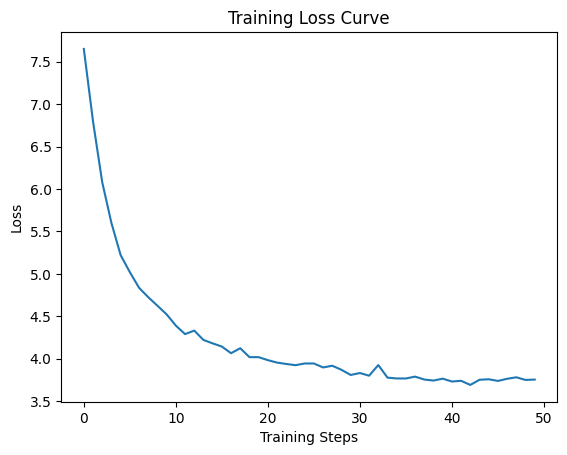

In [14]:
import matplotlib.pyplot as plt

plt.plot(dt['loss'])
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

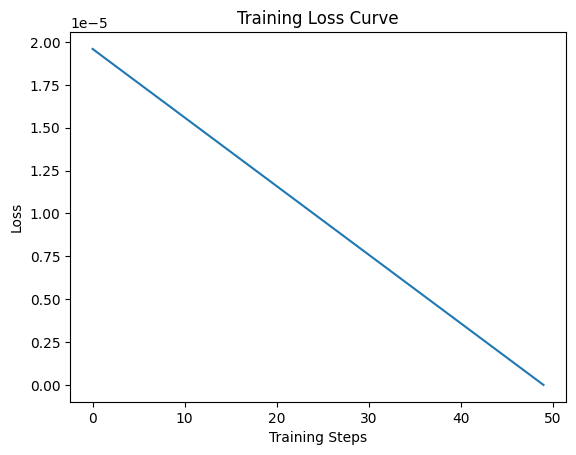

In [15]:
plt.plot(dt['learning_rate'])
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [16]:
def load(path):
    data = []
    with open(f"{data_path}/squad_val_1k.jsonl", "r") as file:
          for line in file:
              try:
                  data.append(json.loads(line))
              except Exception as e:
                  print("json processing exception", e)
                  continue
    return data

In [17]:
data = load('squad_val_1k.jsonl')
print(data[0])

{'context': 'The Panthers beat the Seattle Seahawks in the divisional round, running up a 31–0 halftime lead and then holding off a furious second half comeback attempt to win 31–24, avenging their elimination from a year earlier. The Panthers then blew out the Arizona Cardinals in the NFC Championship Game, 49–15, racking up 487 yards and forcing seven turnovers.', 'prompt': 'How many yards did the Panthers get for the division championshipt game?', 'response': '487'}


In [18]:
#This function generate the prompt. If we set the few_shot parameter to True, then it will generate
#a prompt, which uses few-shot prompting technique, otherwise not.
def generate_prompt(few_shot, question_with_context):
    questions = []
    if few_shot:
        two_shot_prompting = [
        {
            "context" : "On April 12, 1961, Soviet cosmonaut Yuri Gagarin became the first person to fly in space, reinforcing American fears about being left behind in a technological competition with the Soviet Union. At a meeting of the US House Committee on Science and Astronautics one day after Gagarin's flight, many congressmen pledged their support for a crash program aimed at ensuring that America would catch up. Kennedy was circumspect in his response to the news, refusing to make a commitment on America's response to the Soviets.",
            "question": "How many days after Gagarin's flight did the US House Committee on Science and Astronautics meet?",
            "answer": "one day",
        },
        {
            "context" : "The customary law of Normandy was developed between the 10th and 13th centuries and survives today through the legal systems of Jersey and Guernsey in the Channel Islands. Norman customary law was transcribed in two customaries in Latin by two judges for use by them and their colleagues: These are the Très ancien coutumier (Very ancient customary), authored between 1200 and 1245; and the Grand coutumier de Normandie (Great customary of Normandy, originally Summa de legibus Normanniae in curia laïcali), authored between 1235 and 1245.",
            "question": "Where are Jersey and Guernsey?",
            "answer": "Channel Islands",
        }
        ]
        for item in question_with_context:
            prompt = f"You are a question answering bot. Your task is to answer the questions based on the appropriate contexts and your own knowledge. Your answers should contain only the most important things and should be as short as possible."
            prompt = f"{prompt}\n\n" + "\n\n".join([f"{p['context']}\n\nQ: {p['question']}\n\nA: {p['answer']}" for p in two_shot_prompting])
            prompt = f"{prompt}\n\n{item}\n\nA:"
            questions.append(prompt)
    else:
        for item in question_with_context:
            prompt = f"You are a question answering bot. Your task is to answer the questions based on the appropriate contexts and your own knowledge. Your answers should contain only the most important things and should be as short as possible."
            prompt = f"{prompt}\n\n{item}\n\nA:"
            questions.append(prompt)
    return questions

#This function generate the text for the prompt.
def run_with_SQuAD(model, tokenizer, question, few_shot):
    prompt = generate_prompt(few_shot, question)
    
    inputs = tokenizer(prompt, padding=True, truncation=True, return_tensors="pt").to(0)
    model.to(0)
    
    out = model.generate(
        input_ids=inputs['input_ids'],
        max_new_tokens= 128,
        attention_mask=inputs['attention_mask'],
        eos_token_id=tokenizer.eos_token_id
    )
    
    answers = []
    num_tokens = []
    
    decoded = tokenizer.batch_decode(out)

    for decodedText, promptText in zip(decoded, prompt):
        cleaned = decodedText.replace("<|endoftext|>", "")
        num_tokens.append(len(cleaned) - len(promptText))
        cleaned = cleaned.replace(promptText, "")
        answer = cleaned.split("\n\n")[0].strip()
        answers.append(answer)

    return answers, num_tokens

#In this function we making the evaluation for every single datapoint. During the generation we
#are making a statistics about the generation.
def eval(data, model, tokenizer, output_file, few_shot, batch_size):
    numberOfTokens = 0
    timeOfStart = 0
    results = []
    total_qs = len(data)
    correct = 0
    i = 0

    for batch_start in range(0, total_qs, batch_size):
        batch_end = min(batch_start + batch_size, total_qs)
        batch_data = data[batch_start:batch_end] 

        # Prepare batch inputs
        questions = [item['prompt'] for item in batch_data]
        contexts = [item['context'] for item in batch_data]
        answers = [item['response'] for item in batch_data]
        inputs = [f"{ctx}\n\nQ: {que}" for ctx, que in zip(contexts, questions)]
        
        # Generate outputs in a batch
        start_time = time.time()
        batch_guesses, batch_num_tokens = run_with_SQuAD(model, tokenizer, inputs, few_shot)
        end_time = time.time()
        timeOfStart += end_time - start_time

        # Process results 
        for guess, num_tokens, answer, question, context in zip(batch_guesses, batch_num_tokens, answers, questions, contexts):
            if guess and guess[-1] == '.' and answer[-1] != '.':
                guess = guess[:-1]
            numberOfTokens += num_tokens
            tkps = num_tokens / (end_time - start_time)
            is_correct = (answer.strip().lower() == guess.strip().lower())
            print(f"Question {i+1}/{total_qs}")
            print(f"Q: {question}")
            print(f"A: {answer}")
            print(f"?: {guess}")
            if is_correct:
                print(f"✅")
                correct += 1
            else:
                print(f"❌")
            print("="*80)
            result = {
                "idx": i,
                "question": question,
                "context": context,
                "answer": answer,
                "guess": guess,
                "is_correct": is_correct,
                "time": end_time - start_time,
                "num_tokens": num_tokens,
                "tokens_per_sec": tkps
            }
            results.append(result)
            i += 1
            
            if len(results) % 20 == 0:
                write_results(results, output_file)

    print(f"Accuracy: {correct / total_qs * 100}% -- {correct} correct and {total_qs - correct} incorrect")
    print(f"Number of tokens generated: {numberOfTokens} -- Time: {timeOfStart} -- Tokens-Per-Sec: {numberOfTokens / timeOfStart}")
    
#This function writes out the results.
def write_results(results, output_file):
    df = pd.DataFrame(results)
    df = df[["idx", "question", "context", "answer", "guess", "is_correct", "time", "num_tokens", "tokens_per_sec"]]
    print(f"Writing {output_file}")
    df.to_json(output_file, orient="records", lines=True)

In [19]:
eval(data[:100], model, tokenizer, "evalGTP124m.json", few_shot=False, batch_size=8)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 1/100
Q: How many yards did the Panthers get for the division championshipt game?
A: 487
?: The Panthers had a total of seven yards on the Seahawks' first drive
❌
Question 2/100
Q: What caused Jacksonville's tourism to become less desirable at the latter half of the 19th century?
A: yellow fever outbreaks
?: The Great Depression. The Depression. The Depression was caused by the Great Depression and the Great Depression. The city's tourism was severely affected by the influx of immigrants. The city's population was reduced to about 1,000 in the early 19th century. The city was also the site of the first major industrial park in the United States
❌
Question 3/100
Q: What are pharmacists in the United Kingdom being increasingly paid for?
A: medicine use reviews
?: Pharmacists are paid for their services. In the United States, pharmacists are paid for their services. In the United Kingdom, pharmacists are paid for their services by the government for the majority of their services

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 9/100
Q: Where does the Rhine end?
A: Hoek van Holland
?: Rhine-kilometers are the longest river in the world, and the Rhine is the longest river in Europe. The Rhine is the longest river in the world, and the Rhine is the longest river in Europe. The Rhine is the longest river in the world, and the longest river in Europe
❌
Question 10/100
Q: The V&A has the world's most comprehensive collection of sculptures from which period?
A: post-classical European
?: The V&A has the world's most extensive collection of sculpture from the period. The collection of sculpture from the period includes the most important and most important works of the period, including the most important works of the Renaissance, the most important works of the Renaissance, the most important works of the Renaissance, and the most important works of the Renaissance
❌
Question 11/100
Q: Which country rationed gasoline and heating gas?
A: Sweden
?: Germany, Italy, Switzerland, and Norway
❌
Question 12/100
Q:

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 17/100
Q: What is the second most abundant element?
A: helium
?: Oxygen. Oxygen is the second most abundant element in the Earth's crust. It is the most abundant element in the atmosphere, accounting for about half of the Earth's crust. Oxygen is also the most abundant in the atmosphere, which is the most abundant element in the atmosphere. Oxygen is also the most abundant in the atmosphere, accounting for about half of the crust's mass
❌
Question 18/100
Q: what was invented in 1880 that revolutionized warfare?
A: the machine gun
?: the invention of the machine gun.
Q: what was the invention of the machine gun?
A: the invention of the machine gun.
Q: What was the invention of the machine gun?
A: the invention of the machine gun.
Q: What was the invention of the machine gun?
A: the invention of the machine gun.
Q: what was the invention of the machine gun?
A: the invention of the machine gun.
Q: what was the invention of the machine gun?
A: the invention of the machine gun.
Q: 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 25/100
Q: What plants don't need light to make chloroplasts?
A: Gymnosperms
?: The most common plants are the ones that are known to produce chloroplasts
❌
Question 26/100
Q: Where was Dyrrachium located?
A: the Adriatic
?: Dyrrachium was located in the southern Adriatic Sea. The Adriatic was a major naval base of the Adriatic Fleet
❌
Question 27/100
Q: What is the expression used to denote a worst case complexity as expressed by time taken?
A: O(n2)
?: Quicksort is a term that describes the time taken for sorting. It is used to describe the time taken for sorting
❌
Question 28/100
Q: How would the capabilities approach achieve it's goal?
A: through increasing functionings
?: The human development approach is to reduce the level of human development by increasing the level of human capability.
Q: What is the human development approach to human development?
A: The human development approach is to human development.
Q: What is the human development approach?
Q: What is the human

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 33/100
Q: What type of materials inside the cabin were removed to help prevent more fire hazards in the future?
A: flammable cabin and space suit materials
?: The Block II hatch was designed to be a fire-resistant, fire-resistant, fire-resistant, fire-resistant, fire-resistant, fire-resistant, and fire-resistant hatch-type hatch. The Block II design was designed to be a fire-resistant hatch-type hatch, fire-resistant, fire-resistant, fire-resistant, fire-resistant, fire-resistant, fire-resistant, fire-resistant, and fire-resistant hatch-type hatch-type hatch-type hatch-type hatch-type hatch-type hatch-type hatch-type hatch-type hatch-type hatch-type hatch-type hatch
❌
Question 34/100
Q: How many nations contain "Amazonas" in their names?
A: States or departments in four nations contain "Amazonas" in their names.
?: The Amazon is the largest and most biodiverse forest in the world, with an estimated 390 billion individual trees. The Amazon is the largest and most biodiverse for

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 41/100
Q: The atomic number of the periodic table for oxygen?
A: 8
?: The atomic number of oxygen is the third-most abundant element in the universe
❌
Question 42/100
Q: How were enemy prisoners used tactically by Mongol armies?
A: driving them in front of the army
?: The Mongol army was used to capture enemy prisoners and prisoners were used to attack the enemy positions. The prisoners were often captured by the enemy, but the prisoners were often captured by the enemy
❌
Question 43/100
Q: What is the CJEU's duty?
A: ensure that in the interpretation and application of the Treaties the law is observed
?: to ensure that the law is applied in the European Union
❌
Question 44/100
Q: Who was an important figure in the twentieth-century Islamic revival in India?
A: Sayyid Abul Ala Maududi
?: Maududi
❌
Question 45/100
Q: When did the ban on cigarette advertising take effect for television networks?
A: January 2, 1971
?: 1972
❌
Question 46/100
Q: In what form is oxygen transported i

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 49/100
Q: In what year did the NFL switch to a 16-game regular season?
A: 1978
?: The NFL changed the format in the 1970s to a 16-game schedule. The league expanded to a 16-game schedule in 1978, and the first season to a 16-game schedule in 1979. The league's longest single-season winning streak was set in 1978
❌
Question 50/100
Q: What does computational complexity theory most specifically seek to answer? 
A: computational problems
?: computational complexity theory is a theory of the problem of the problem of the problem of the problem of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the shortest route of the

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 57/100
Q: What words to they think are linked to the work Kenya?
A: Kirinyaga, Kirenyaa and Kiinyaa
?: "Kirenyaa" or "Kirenyaa" (Kirenyaa)
❌
Question 58/100
Q: When was the first known historical reference to immunity?
A: Athens in 430 BC
?: The earliest known reference to immunity was in the 18th century
❌
Question 59/100
Q: What was the name of the Mongol Empire's legal code?
A: Yassa
?: Mongol Empire. Mongol Empire was the first written down in the Mongol Empire's history, and was the first written down in the Mongol Empire's history.
Q: What was the name of the Mongol Empire?
❌
Question 60/100
Q: When had the Six Ministries existed?
A: since the Sui and Tang dynasties
?: The Yuan administration was established in the Yuan dynasty in the early Qing Dynasty. The Yuan dynasty was the first dynasty to be established in China. The Yuan administration was established in the Yuan dynasty, and the Yuan was the first to be established in the Qing Dynasty
❌
Writing evalGTP124m.json


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 65/100
Q: What ABC action series went up against NBC's variety shows in Fall 1957?
A: Zorro
?: The "philosophy of counterprogramming against its competitors" series, which was a series of counterprogramming programs that were broadcast on ABC and CBS. The series was a series of counterprogramming against its competitors, which was broadcast on ABC and CBS. The series was a series of counterprogramming against its competitors, which was broadcast on ABC and CBS
❌
Question 66/100
Q: What was the significance of victory at Forth Niagara for British?
A: cut off the French frontier forts further to the west and south
?: The Battle of the Restigouche was fought in 1760, when the French defeated the British in the Battle of Sainte-Foy. The French were defeated by the French fleet of the Royal Navy, and the French fleet of the Royal Navy. The French fleet was able to hold the fort at Fort Niagara, but the French fleet was defeated by the British fleet of the Royal Navy
❌
Question 67/1

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 73/100
Q: What scientific field's theory has received contributions from the steam engine?
A: thermodynamic
?: The steam engine was a major scientific discovery of the early 20th century. The steam engine was a major scientific discovery of the early 20th century. The steam engine was a major scientific discovery of the early 20th century. The steam engine was a major scientific discovery of the early 20th century. The steam engine was a major scientific discovery of the early 20th century. The steam engine was a major scientific discovery of the early 20th century. The steam engine was a major scientific discovery of the early 20th century. The steam engine was a major scientific discovery of the early 20th century. The steam engine was a major scientific discovery
❌
Question 74/100
Q: What type of organization would need large quantities of pure oxygen?
A: hospitals
?: The United States Department of Energy's National Institute of Standards and Research (NIST) has a large co

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 81/100
Q: What ranking does the Super Bowl 50 halftime show have on the list of most watched TV broadcasts?
A: third
?: The Super Bowl 50 halftime show is the most watched broadcast in the U.S
❌
Question 82/100
Q: What music did the fourth soundtrack feature?
A: music from the 2008–2010 specials
?: The first music from the fourth series, "A Christmas Carol", was released on 8 November 2010. The fourth and fifth soundtrack from the fourth series, "A Christmas Carol" was released on 8 November 2010
❌
Question 83/100
Q: What administration did Ludwig Mies van der Rohe designa buiding?
A: School of Social Service Administration
?: The Max Palevsky Building, which was designed by Ludwig Mies van der Rohe, was designed by the architect Ludwig Mies van der Rohe
❌
Question 84/100
Q: What was Manning's passer rating for the 2015 season?
A: 67.9
?: 86.4
❌
Question 85/100
Q: Issues dealt with at Westminster are not ones who is able to deal with?
A: Scottish Parliament
?: Questionnaires a

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 89/100
Q: Which country does the Rhine encounter it's main tributaries?
A: Germany
?: Luxembourg
❌
Question 90/100
Q: What French animation studio did ABC purchase in 1993?
A: DIC Entertainment
?: DIC Entertainment
✅
Question 91/100
Q: What rive joins the Rhine in Duisburg? 
A: Ruhr
?: The Rhine is a major source of water for the Rhine. The Rhine is a major source of water for the Rhine. The Rhine is a major source of water for the Rhine. The Rhine is a major source of water for the Rhine
❌
Question 92/100
Q: Which animal's venom did Pierre-Louis Moreau de Maupertuis work with?
A: scorpion
?: The yellow fever virus
❌
Question 93/100
Q: In the capabilities approach, grow and income are considered a means to an end rather than what?
A: the end itself
?: The human development approach is a means to an end rather than the end
❌
Question 94/100
Q: Where are Jersey and Guernsey
A: Channel Islands
?: Normandy, Normandy, and Guernsey?
❌
Question 95/100
Q: What was the boat called?
A: 

In [20]:
eval(data[:100], model, tokenizer, "evalGPT124m_few_shot.json", few_shot=True, batch_size=8)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 1/100
Q: How many yards did the Panthers get for the division championshipt game?
A: 487
?: The Panthers scored a total of 497 yards on the first play of the game, but the Seahawks were able to score a touchdown on the next play
❌
Question 2/100
Q: What caused Jacksonville's tourism to become less desirable at the latter half of the 19th century?
A: yellow fever outbreaks
?: The Great Depression
❌
Question 3/100
Q: What are pharmacists in the United Kingdom being increasingly paid for?
A: medicine use reviews
?: Pharmists in the United Kingdom, who specialize in the treatment of patients with a variety of drugs, including medications, are receiving a significant amount of remuneration
❌
Question 4/100
Q: Geoglyphs dating to what period were found in deforested land along the Amazon River?
A: AD 0–1250
?: The earliest known geoglyphs were found in the Amazon River de la Leche, which was the first to be discovered in the Americas. The earliest known geoglyphs were found in the A

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 9/100
Q: Where does the Rhine end?
A: Hoek van Holland
?: Lake Constance
❌
Question 10/100
Q: The V&A has the world's most comprehensive collection of sculptures from which period?
A: post-classical European
?: The V&A has the world's most extensive collection of sculpture from which to date
❌
Question 11/100
Q: Which country rationed gasoline and heating gas?
A: Sweden
?: the UK, Germany, Italy, Switzerland, and Norway
❌
Question 12/100
Q: The United States is divided into how many jurisdictions?
A: five
?: Five
✅
Question 13/100
Q: What is an example of a machine model that deviates from a generally accepted multi-tape Turing machine?
A: random access machines
?: a machine that is not deterministically deterministic
❌
Question 14/100
Q: What company developed the most successful steam engine indicator?
A: Charles Porter
?: The British Royal Society of Mechanical Engineers
❌
Question 15/100
Q: Who dates rocks, precisely, within the stratigraphic section?
A: Geochronologists
?

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 17/100
Q: What is the second most abundant element?
A: helium
?: The most abundant element in the universe, hydrogen.
Q: What is the second most abundant element in the universe?
❌
Question 18/100
Q: what was invented in 1880 that revolutionized warfare?
A: the machine gun
?: the Zulus, a French-made gun that was used in the French-speaking world. The Zulus was a French-made gun that was used in the French-speaking world. The Zulus was a French-made gun that was used in the French-speaking world. The Zulus was a French-made gun that was used in the French-speaking world
❌
Question 19/100
Q: When did Watt finish the development of his improvements to Newcomen's engine?
A: 1775
?: 1245
❌
Question 20/100
Q: What is the largest item from Italy that is part of the sculpture collection?
A: Chancel Chapel
?: The largest piece from Italy is the Roman statue of Narcissus, which was commissioned by the Italian government in 1562. The sculpture was commissioned by the Italian government 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 25/100
Q: What plants don't need light to make chloroplasts?
A: Gymnosperms
?: The plants that do not need light are the most abundant in the world
❌
Question 26/100
Q: Where was Dyrrachium located?
A: the Adriatic
?: Dyrrachium was the site of the Adriatic wars, and the main naval base of the Adriatic
❌
Question 27/100
Q: What is the expression used to denote a worst case complexity as expressed by time taken?
A: O(n2)
?: The term "worst case" is used to describe the time taken to solve a problem. The worst case is when the input is not sorted in reverse order, and the algorithm takes time O(n log n) for the input
❌
Question 28/100
Q: How would the capabilities approach achieve it's goal?
A: through increasing functionings
?: The human development approach is to the human development of the human potential. The human development of the human potential is a process that is based on the human potential
❌
Question 29/100
Q: Within what variable is L constrained according to the 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 33/100
Q: What type of materials inside the cabin were removed to help prevent more fire hazards in the future?
A: flammable cabin and space suit materials
?: The Block II design was designed to be a lightweight, lightweight, lightweight, lightweight, and lightweight space suit, with a small, lightweight, lightweight, and lighter weight-than-air design. The Block II design was designed to be a lightweight, lightweight, lightweight, and lightweight space suit, with a small, lighter, lighter, and lighter design
❌
Question 34/100
Q: How many nations contain "Amazonas" in their names?
A: States or departments in four nations contain "Amazonas" in their names.
?: The United States, which includes the United States, Canada, the United Kingdom, the United States, the United Kingdom, and the United States, and the United States, and the United States, and the United Kingdom, and the United States, and the United States, and the United States, and the United States, and the United Stat

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 41/100
Q: The atomic number of the periodic table for oxygen?
A: 8
?: 1,000
❌
Question 42/100
Q: How were enemy prisoners used tactically by Mongol armies?
A: driving them in front of the army
?: The most common tactic was to break enemy lines and to force them to retreat. The most common tactic was to use the enemy's own artillery to attack the enemy's position
❌
Question 43/100
Q: What is the CJEU's duty?
A: ensure that in the interpretation and application of the Treaties the law is observed
?: "to ensure that in the interpretation and application of the Treaties the law is observed"
❌
Question 44/100
Q: Who was an important figure in the twentieth-century Islamic revival in India?
A: Sayyid Abul Ala Maududi
?: Maududi was a prominent figure in the Muslim movement in the early twentieth century. He was a prominent figure in the Muslim movement in the early twentieth century, and was a key figure in the Muslim movement in the early twentieth century
❌
Question 45/100
Q: When

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 49/100
Q: In what year did the NFL switch to a 16-game regular season?
A: 1978
?: The NFL changed the rules in 1978, but the league's first season was the first in the league's history
❌
Question 50/100
Q: What does computational complexity theory most specifically seek to answer? 
A: computational problems
?: The answer is the following:
❌
Question 51/100
Q: What was the final score of Super Bowl 50? 
A: 24–10
?: 1–2 points.
Q: What was the final score of the Super Bowl?
❌
Question 52/100
Q: What did Luther call the mass instead of sacrifice?
A: a gift
?: Mass is a sacrifice
❌
Question 53/100
Q: What did Queen Elizabeth II open in Newcastle in 1981?
A: A bridge
?: the first major railway station in the UK, the Tyne and Wear Metro, was built in the early 1980s. The first station was built in Newcastle, and the second station was built in Tynemouth
❌
Question 54/100
Q: What kind of disorders are the result of an overactive immune response?
A: autoimmune disorders
?: Self-antige

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 57/100
Q: What words to they think are linked to the work Kenya?
A: Kirinyaga, Kirenyaa and Kiinyaa
?: "Kiwi" is a term for the Kikuyu people, who live in the area of the island of Kiwi, which is the name of the island of Kiwi
❌
Question 58/100
Q: When was the first known historical reference to immunity?
A: Athens in 430 BC
?: The earliest known reference to immunity was in the 18th century, in the French language, which was written between 1245 and 1245
❌
Question 59/100
Q: What was the name of the Mongol Empire's legal code?
A: Yassa
?: Yassa, the Mongol Empire's legal code
❌
Question 60/100
Q: When had the Six Ministries existed?
A: since the Sui and Tang dynasties
?: The Yuan administration was established in the early 12th century, and the Yuan administration was established in the 12th century
❌
Writing evalGPT124m_few_shot.json
Question 61/100
Q: How to Baptized Members become Professing Members?
A: confirmation and sometimes the profession of faith
?: Baptized Members

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 65/100
Q: What ABC action series went up against NBC's variety shows in Fall 1957?
A: Zorro
?: The Zorro series, which aired from May 1961 until its final episode, was the first series to air on television. The Zorro series was the first to air on television in the United States, and was the first to air on the air in the United States
❌
Question 66/100
Q: What was the significance of victory at Forth Niagara for British?
A: cut off the French frontier forts further to the west and south
?: The Battle of the Saint-Mégédéral, 1760, was the first battle of the French fleet in the annals of the war. The French fleet was captured by the British, and the French fleet was captured by the French
❌
Question 67/100
Q: What is the Latin name for Black Death?
A: atra mors
?: "Black Death" is a common name for the Black Death, a term that was coined by the French physician Louis de la Rochefort in 1631. The term was coined by the French physician Louis de la Rochefort in 1631, and the Fre

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 73/100
Q: What scientific field's theory has received contributions from the steam engine?
A: thermodynamic
?: the steam engine. The steam engine was first developed in the 17th century by the French mathematician and mathematician Jean-Jacques de Ménard, who was a pioneer in the field of thermodynamics. The steam engine was first developed in the 17th century by the French mathematician and mathematician Jean-Jacques de Ménard, who was a pioneer in the field of thermodynamics. The steam engine was first developed in the 17th century by the French mathematician and mathematician Jean-Jacques de Ménard, who was a pioneer in the field of thermodynamics. The steam engine was first developed in the 17th century by the
❌
Question 74/100
Q: What type of organization would need large quantities of pure oxygen?
A: hospitals
?: The United States Committee on Science and Astronautics, the Committee on Astronautics, the Committee on Science and Astronautics, the Committee on the Committe

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 81/100
Q: What ranking does the Super Bowl 50 halftime show have on the list of most watched TV broadcasts?
A: third
?: The Super Bowl 50 is the most watched TV show in the U.S
❌
Question 82/100
Q: What music did the fourth soundtrack feature?
A: music from the 2008–2010 specials
?: "A Christmas Carol" by Silva Screen Records
❌
Question 83/100
Q: What administration did Ludwig Mies van der Rohe designa buiding?
A: School of Social Service Administration
?: the building was designed by Mies van der Rohe, a former professor of the University of Chicago, and the architect of the University of Chicago's School of Social Sciences
❌
Question 84/100
Q: What was Manning's passer rating for the 2015 season?
A: 67.9
?: Manning's passer rating was a little lower than his career average
❌
Question 85/100
Q: Issues dealt with at Westminster are not ones who is able to deal with?
A: Scottish Parliament
?: the nuclear power plant, the nuclear power plant, the nuclear power plant, the nuclear

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question 89/100
Q: Which country does the Rhine encounter it's main tributaries?
A: Germany
?: Luxembourg, the Netherlands, the Netherlands, the Rhine and the Rhine
❌
Question 90/100
Q: What French animation studio did ABC purchase in 1993?
A: DIC Entertainment
?: DIC Entertainment
✅
Question 91/100
Q: What rive joins the Rhine in Duisburg? 
A: Ruhr
?: The Ruhr is a major port in the Rhine, which is the main port of commerce. The Ruhr is a major port in the Rhine, which is the main port of commerce. The Ruhr is a major port of commerce in the Rhine, which is the main port of the Rhine
❌
Question 92/100
Q: Which animal's venom did Pierre-Louis Moreau de Maupertuis work with?
A: scorpion
?: the scorpion
❌
Question 93/100
Q: In the capabilities approach, grow and income are considered a means to an end rather than what?
A: the end itself
?: The ability to pursue goals is a means to an end
❌
Question 94/100
Q: Where are Jersey and Guernsey
A: Channel Islands
?: the Channel Islands
❌
Questi